## 1) Import libraries

In [1]:
import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages")

import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt

from functions import *

import pickle

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

from scipy import sparse

import math

In [2]:
def splitAtUpperCase(s):
    for i in range(len(s)-1)[::-1]:
        if s[i].isupper() and s[i+1].islower():
            s = s[:i]+' '+s[i:]
        if s[i].isupper() and s[i-1].islower():
            s = s[:i]+' '+s[i:]
        if s[i].isdigit() and s[i+1].isalpha():
            s = s[:i+1]+' '+s[i+1:]
        if s[i].isdigit() and s[i-1].isalpha():
            s = s[:i]+' '+s[i:]
        if s[i].isalpha() and s[i+1].isdigit():
            s = s[:i+1]+' '+s[i+1:]
        if s[i].isalpha() and s[i-1].isdigit():
            s = s[:i]+' '+s[i:]
    return s.split()

## 2) Import data

In [3]:
data = pd.read_csv("dataset_whole.csv", index_col = 0)

In [4]:
len(data["connRef"].unique())

37

In [5]:
data = pd.read_csv("dataset_whole.csv", index_col = 0)
data = data.drop(["inverted"],axis=1)
data_serviceType = pd.read_csv("dataset_whole_1.csv", index_col = 0)[["connRef","serviceType"]]

In [6]:
building_test = data["connRef"].unique()[0]

In [7]:
building_test

'LBG 50014000 Brindley Place'

In [8]:
test = data[data["connRef"]==building_test]
train = data[data["connRef"]!=building_test]

In [9]:
serviceType_test = data_serviceType[data_serviceType["connRef"]==building_test][["serviceType"]]
serviceType_train = data_serviceType[data_serviceType["connRef"]!=building_test][["serviceType"]]

In [10]:
serviceType_test

serviceType
id                                                             
50014000 Brindley Place Cooling 5th flr Cash            Cooling
50014000 Brindley Place Cooling 5th Post Room S...      Cooling
50014000 Brindley Place Cooling 6th flr Kitchen         Cooling
50014000 Brindley Place Cooling 6th flr Kitchen...      Cooling
50014000 Brindley Place Cooling 6th flr Meeting         Cooling
50014000 Brindley Place Cooling 6th flr Meeting...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant           Cooling
50014000 Brindley Place Cooling Chiller Plant           Cooling
50014000 Brindley Place Cooling Chiller Plant           Cooling
50014000 Brindley Place Cooling Chiller Plant           Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant C...      Cooling
50014000 Brindley Place Cooling Chiller Plant S...      Cooling
50014000 Brindley Place Cooling Chiller Plant S...      Cooling
50014000 Brindley Place Cooling Chiller Plant S...      Cooling
...                                                         ...
50014000 Brindley Place Ventilation West AHU Se...  Ventilation
50014000 Brindley Place Ventilation West AHU Se...  Ventilation
50014000 Brindley Place Ventilation West AHU Se...  Ventilation
50014000 Brindley Place Ventilation West AHU Su...  Ventilation
50014000 Brindley Place Ventilation West AHU Su...  Ventilation
50014000 Brindley Place Ventilation West AHU Su...  Ventilation
50014000 Brindley Place Ventilation West AHU Su...  Ventilation
50014000 Brindley Place Ventilation West AHU Su...  Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation
50014000 Brindley Place Ventilation West AHU        Ventilation

[1820 rows x 1 colu

In [11]:
X_train = train[["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"]]
X_test = test[["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"]]

y_train = train.drop(["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"], axis = 1)
y_test = test.drop(["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"], axis = 1)

In [12]:
data.head()

navName                      connRef contractRef  \
0  5thFlr DX3 Cash Office Enable  LBG 50014000 Brindley Place         LBG   
1   DX Unit 3 5th Post Room Temp  LBG 50014000 Brindley Place         LBG   
2      6thFlr DX1 Kitchen Enable  LBG 50014000 Brindley Place         LBG   
3    DX Unit 1 Kitchen Room Temp  LBG 50014000 Brindley Place         LBG   
4      6thFlr DX2 Meeting Enable  LBG 50014000 Brindley Place         LBG   

  controllerReference pointReference    kind unit  hisInterval  hisSize  air  \
0               L1O11        D11(Sv)    Bool    0        300.0  58820.0    0   
1               L1O11         S10(V)  Number   °C        300.0  58822.0    1   
2               L1O11         D9(Sv)    Bool    0        300.0  58823.0    0   
3               L1O11          S8(V)  Number   °C        300.0  58816.0    1   
4               L1O11        D10(Sv)    Bool    0        300.0  58820.0    0   

   ...  recirc  return  run  sensor  sp  speed  temp  valve  water  zone  
0  ...       0       0    0       0   0      0     0      0      0     0  
1  ...       0       0    0       1   0      0     1      0      0     0  
2  ...       0       0    0       0   0      0     0      0      0     0  
3  ...       0       0    0       1   0      0     1      0      0     0  
4  ...       0       0    0       0   0      0     0      0      0     0  

[5 rows x 47 columns]

## 3) Parsing Data

### Uncomment when not selecting a specific building

In [13]:
#from sklearn.model_selection import train_test_split

In [14]:
#X = data[["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"]]
#y = data.drop(["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"], axis = 1)

In [15]:
#X_train, X_test, y_train, y_test, serviceType_train, serviceType_test = train_test_split(X.reset_index(drop=True), y.reset_index(drop=True), data_serviceType, test_size=0.1, random_state=42)

--------------------------------------------------------------------------------------------------

In [16]:
y_train_1 = y_train[["cmd", "sp", "sensor"]]
y_test_1 = y_test[["cmd", "sp", "sensor"]]

header = y_train.columns.tolist()
header.remove("cmd")
header.remove("sp")
header.remove("sensor")
y_train_2 = y_train[header]
y_test_2 = y_test[header]

### 3.1) Labels (navName)

In [17]:
labels_list_train = X_train[["navName"]].values.tolist()
labels_list_test = X_test[["navName"]].values.tolist()

In [18]:
# importing modules 
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
   
ps = PorterStemmer() 

In [19]:
dictionary = pd.read_csv("dict.csv",header=None).set_index(0).T.to_dict("list")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.


In [20]:
def labels_processing(labels_list, dictionary):
    labels = []
    for label in labels_list:
        
        #label = splitAtUpperCase(label[0])

        #label = label[0].lower()
        #print(label)
        #label = re.sub(r"[0-9]","",label)
        label = re.sub("[.]"," ",label[0])
        #label = label.lower().split()
        label = splitAtUpperCase(label)
        for i in range(0,len(label)):
            label[i] = label[i].lower()
            if label[i] in dictionary:
                label[i] = dictionary[label[i]][0]
        #label = " ".join(label)
        labels += [label] 
        
    return labels

In [21]:
labels_list_train

[['Outside Air Temp'],
 ['Outside Air Temp'],
 ['OAT Hold Off'],
 ['External Frost SP'],
 ['Fabric Protection'],
 ['Internal Frost SP'],
 ['NE Htg OAT Hold Off'],
 ['NW Htg OAT Hold Off'],
 ['OAT Hold Off'],
 ['SE Htg OAT Hold Off'],
 ['FrostLvl Start Plant'],
 ['FrostLvl Start Pumps'],
 ['SW Htg OAT Hold Off'],
 ['Boiler Pump 1 Failed'],
 ['Boiler Circ Pp2 Trip'],
 ['Boiler Pump 2 Failed'],
 ['Boiler Pump Failed'],
 ['Boiler Pumps 1&2'],
 ['Boiler Pumps Flow'],
 ['Bypass Pumps'],
 ['Computer Pump Failed'],
 ['Computer Pump Flow'],
 ['Computer Pumps'],
 ['CT Pump 1 Failed'],
 ['CT Pump 1 Trip'],
 ['CT Pump 2 Failed'],
 ['CT Pump 2 Trip'],
 ['CT Pump Failed'],
 ['CT Pump Flow'],
 ['CT Pumps 1&2'],
 ['CT Pumps'],
 ['2nd East Space K25'],
 ['East Flow Temp'],
 ['East Pump Failed'],
 ['East Zone Pump Flow'],
 ['East Zone Pumps'],
 ['East VT Valve'],
 ['East Space SP'],
 ['East VT Slope'],
 ['Boiler 1 Hi Temp Alm'],
 ['Boiler 1 Lock Out'],
 ['Boiler enable'],
 ['Boiler 1 Firing'],
 ['Boiler

In [22]:
labels_train = labels_processing(labels_list_train, dictionary)
labels_test = labels_processing(labels_list_test, dictionary)

In [23]:
labels = []
for w in labels_train:
    labels += [[ps.stem(word) for word in w]]
labels_train = labels
labels = []
for w in labels_test:
    labels += [[ps.stem(word) for word in w]]
labels_test = labels

In [24]:
labels_train = [" ".join(i) for i in labels_train]
labels_test = [" ".join(i) for i in labels_test]

In [25]:
labels_train

['outsid air temp',
 'outsid air temp',
 'oat hold off',
 'extern frost sp',
 'fabric protect',
 'intern frost sp',
 'ne heat oat hold off',
 'nw heat oat hold off',
 'oat hold off',
 'se heat oat hold off',
 'frost lvl start plant',
 'frost lvl start pump',
 'sw heat oat hold off',
 'boiler pump 1 fail',
 'boiler flow pp 2 trip',
 'boiler pump 2 fail',
 'boiler pump fail',
 'boiler pump 1&2',
 'boiler pump flow',
 'bypass pump',
 'comput pump fail',
 'comput pump flow',
 'comput pump',
 'ct pump 1 fail',
 'ct pump 1 trip',
 'ct pump 2 fail',
 'ct pump 2 trip',
 'ct pump fail',
 'ct pump flow',
 'ct pump 1&2',
 'ct pump',
 '2 nd east space k 25',
 'east flow temp',
 'east pump fail',
 'east zone pump flow',
 'east zone pump',
 'east vt valv',
 'east space sp',
 'east vt slope',
 'boiler 1 high temp alm',
 'boiler 1 lock out',
 'boiler enabl',
 'boiler 1 fire',
 'boiler flow sp',
 'boiler flow temp',
 'boiler return temp',
 'cmn boiler flow temp',
 'optimis time',
 'boiler modul',
 'ga 

In [26]:
from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
count_vect = CountVectorizer(ngram_range=(1,1))
count_vect.fit(labels_train)
count_vect.fit(labels_test)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [27]:
labels_sparse_train = count_vect.transform(labels_train)
labels_sparse_test = count_vect.transform(labels_test)

In [28]:
# Helper function
#def print_topics(model, count_vectorizer, n_top_words):
 #   words = count_vectorizer.get_feature_names()
  #  for topic_idx, topic in enumerate(model.components_):
   #     print("\nTopic #%d:" % topic_idx)
    #    print(" ".join([words[i]
     #                   for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [29]:
# Load the LDA model from sk-learn
#from sklearn.decomposition import LatentDirichletAllocation as LDA
# Tweak the two parameters below
#number_topics = 20
#number_words = 10
# Create and fit the LDA model
#lda = LDA(n_components=number_topics)
#lda.fit(labels_sparse_train)

In [30]:
#labels_sparse_train.shape

In [31]:
#lda_categories_train = lda.transform(labels_sparse_train)
#lda_categories_test = lda.transform(labels_sparse_test)

In [32]:
#print_topics(lda, count_vect, number_words)

In [33]:
#lda_sparse_train = sparse.csr_matrix(lda_categories_train)
#lda_sparse_test = sparse.csr_matrix(lda_categories_test)

### 3.2) Lan/outstation

In [34]:
lanOut = [re.sub("\D"," ",field[0]).split() for field in data[["controllerReference"]].values.tolist()]

lanOut_train = [re.sub("\D"," ",field[0]).split() for field in X_train[["controllerReference"]].values.tolist()]
lanOut_test = [re.sub("\D"," ",field[0]).split() for field in X_test[["controllerReference"]].values.tolist()]

In [35]:
#transform in "int" type the first vector member
for i in range(0, len(lanOut)):
    lanOut[i][0]=int(lanOut[i][0])
for i in range(0, len(lanOut_train)):
    lanOut_train[i][0]=int(lanOut_train[i][0])
for i in range(0, len(lanOut_test)):
    lanOut_test[i][0]=int(lanOut_test[i][0])

In [36]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(lanOut)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [37]:
lanOut_train = enc.transform(lanOut_train)
lanOut_test = enc.transform(lanOut_test)

In [38]:
lanOut_sparse_train = sparse.csr_matrix(lanOut_train)
lanOut_sparse_test = sparse.csr_matrix(lanOut_test)

In [39]:
lanOut_sparse_train.shape, lanOut_sparse_test.shape

((40472, 155), (1820, 155))

### 3.3) Controller Ref

In [40]:
controllerRef = data[["pointReference"]].values.tolist()

controllerRef_train = X_train[["pointReference"]].values.tolist()
controllerRef_test = X_test[["pointReference"]].values.tolist()

In [41]:
#Substitute parenthesis by blank space
conRef_process1 = [re.sub("[()]"," ",controllerRef[i][0]) for i in range(0,len(controllerRef))]

conRef_process1_train = [re.sub("[()]"," ",controllerRef_train[i][0]) for i in range(0,len(controllerRef_train))]
conRef_process1_test = [re.sub("[()]"," ",controllerRef_test[i][0]) for i in range(0,len(controllerRef_test))]

In [42]:
third_field = [conRef_process1[i].split()[1] for i in range(0,len(conRef_process1))]

third_field_train = [conRef_process1_train[i].split()[1] for i in range(0,len(conRef_process1_train))]
third_field_test = [conRef_process1_test[i].split()[1] for i in range(0,len(conRef_process1_test))]

In [43]:
first_field = [conRef_process1[i][0] for i in range(0,len(conRef_process1))]

first_field_train = [conRef_process1_train[i][0] for i in range(0,len(conRef_process1_train))]
first_field_test = [conRef_process1_test[i][0] for i in range(0,len(conRef_process1_test))]

In [44]:
second_field = [conRef_process1[i].split()[0][1:] for i in range(0,len(conRef_process1))]

second_field_train = [conRef_process1_train[i].split()[0][1:] for i in range(0,len(conRef_process1_train))]
second_field_test = [conRef_process1_test[i].split()[0][1:] for i in range(0,len(conRef_process1_test))]

In [45]:
conRef = [[first_field[i],second_field[i],third_field[i]] for i in range(0, len(first_field))]

conRef_train = [[first_field_train[i],second_field_train[i],third_field_train[i]] for i in range(0, len(first_field_train))]
conRef_test = [[first_field_test[i],second_field_test[i],third_field_test[i]] for i in range(0, len(first_field_test))]

In [46]:
enc_ref = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_ref.fit(conRef)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [47]:
conRef_train = enc_ref.transform(conRef_train)
conRef_test = enc_ref.transform(conRef_test)

In [48]:
conRef_sparse_train = sparse.csr_matrix(conRef_train)
conRef_sparse_test = sparse.csr_matrix(conRef_test)

In [49]:
conRef_sparse_train.shape, conRef_sparse_test.shape

((40472, 237), (1820, 237))

### 3.4) Kind

In [50]:
kind = data[["kind"]].values.tolist()

kind_train = X_train[["kind"]].values.tolist()
kind_test = X_test[["kind"]].values.tolist()

enc_kind = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_kind.fit(kind)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [51]:
kind_train = enc_kind.transform(kind_train)
kind_test = enc_kind.transform(kind_test)

In [52]:
kind_sparse_train = sparse.csr_matrix(kind_train)
kind_sparse_test = sparse.csr_matrix(kind_test)

### 3.5) Units

In [53]:
units = data[["unit"]].values.tolist()

units_train = X_train[["kind"]].values.tolist()
units_test = X_test[["kind"]].values.tolist()

enc_units = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_units.fit(units)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [54]:
units_train = enc_units.transform(units_train)
units_test = enc_units.transform(units_test)

In [55]:
units_sparse_train = sparse.csr_matrix(units_train)
units_sparse_test = sparse.csr_matrix(units_test)

## 4) Concatenate all

In [56]:
sX_train = sparse.hstack([labels_sparse_train,conRef_sparse_train,lanOut_sparse_train,kind_sparse_train,units_sparse_train])
sX_test = sparse.hstack([labels_sparse_test,conRef_sparse_test,lanOut_sparse_test,kind_sparse_test,units_sparse_test])

In [57]:
sX_train.shape, sX_test.shape

((40472, 653), (1820, 653))

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [59]:
from xgboost import XGBClassifier

In [60]:
y_train_1_XGBoost = np.argmax(y_train_1.values, axis=1)
y_test_1_XGBoost = np.argmax(y_test_1.values, axis=1)

In [61]:
%%time

# initialize label powerset multi-label classifier
classifier_1 = XGBClassifier()
#classifier_1 = RandomForestClassifier(n_estimators=100)

# train
classifier_1.fit(sX_train,y_train_1_XGBoost)

# predict
predictions = classifier_1.predict(sX_test)
#predictions_val = classifier.predict(data_val)

# accuracy
print("Accuracy = ",accuracy_score(y_test_1_XGBoost,predictions))
print("\n")

Accuracy =  0.9983516483516484


CPU times: user 4.18 s, sys: 9.03 ms, total: 4.19 s
Wall time: 4.19 s


In [62]:
probabilities_1 = classifier_1.predict_proba(sX_test)

In [63]:
threshold = 0.80

In [64]:
probabilities_1[1]

array([0.00189213, 0.00170903, 0.9963988 ], dtype=float32)

In [65]:
predictions.shape, sX_test.shape, y_train_2.shape, y_train_1.shape

((1820,), (1820, 653), (40472, 35), (40472, 3))

In [66]:
predictions = np.reshape(predictions,(-1,1))

In [67]:
predictions.shape

(1820, 1)

In [68]:
enc = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(predictions)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [69]:
spredictions = enc.transform(predictions)

In [70]:
spredictions.toarray().shape, y_train_1.shape

((1820, 3), (40472, 3))

In [71]:
sX_test.shape, spredictions.shape

((1820, 653), (1820, 3))

In [72]:
y_train_1 = sparse.csr_matrix(y_train_1.values) 

In [73]:
y_train_1.shape

(40472, 3)

In [74]:
#Preparing new test data (test_1 + predictions)
#spredictions = sparse.csr_matrix(predictions) 
sX_test_2 = sparse.hstack([sX_test,spredictions])

#Preparing new training data (train_1 + y_train_1)
sX_train_2 = sparse.hstack([sX_train,y_train_1])

In [75]:
sX_test_2.shape, sX_train_2.shape

((1820, 656), (40472, 656))

In [76]:
results_2 = np.empty(sX_test_2.shape[0])
results_2 = np.reshape(results_2, (-1,1))

probabilities_2 = np.empty(sX_test_2.shape[0])
probabilities_2 = np.reshape(probabilities_2, (-1,1))

In [77]:
for category in list(y_train_2):
    
    classifier_2 = XGBClassifier()
    classifier_2.fit(sX_train_2, y_train_2[[category]])
    
    # predict
    predictions_2 = classifier_2.predict(sX_test_2)
    probs_2 = classifier_2.predict_proba(sX_test_2)
    
    predictions_train_2 = classifier_2.predict(sX_train_2)
    #predictions_val = classifier.predict(data_val)
    
    predictions_2 = np.reshape(predictions_2, (-1,1))
    results_2 = np.concatenate((results_2, predictions_2), axis=1)
    
    #probs_2 = np.reshape(probs_2, (-1,1))
    
    probs_2 = probs_2[:,[1]]
    print(probs_2.shape)
    
    probabilities_2 = np.concatenate((probabilities_2, probs_2), axis=1)
    
    # accuracy
    print(category)
    print(probabilities_2.shape)
    print("Training Accuracy = ",accuracy_score(y_train_2[[category]],predictions_train_2))
    print("Test Accuracy = ",accuracy_score(y_test_2[[category]],predictions_2))
    print("\n")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1820, 1)
air
(1820, 2)
Training Accuracy =  0.9494218224945642
Test Accuracy =  0.9741758241758242


(1820, 1)
alarm
(1820, 3)
Training Accuracy =  0.9719806285827238
Test Accuracy =  0.9868131868131869


(1820, 1)
chilled
(1820, 4)
Training Accuracy =  0.9969114449495948
Test Accuracy =  1.0


(1820, 1)
co2
(1820, 5)
Training Accuracy =  0.9998023324767741
Test Accuracy =  0.9989010989010989


(1820, 1)
cool
(1820, 6)
Training Accuracy =  0.997034987151611
Test Accuracy =  0.9989010989010989


(1820, 1)
damper
(1820, 7)
Training Accuracy =  0.9985422020162087
Test Accuracy =  0.9950549450549451


(1820, 1)
discharge
(1820, 8)
Training Accuracy =  0.9851255188772484
Test Accuracy =  0.9901098901098901


(1820, 1)
enable
(1820, 9)
Training Accuracy =  0.9995305396323384
Test Accuracy =  1.0


(1820, 1)
energy
(1820, 10)
Training Accuracy =  1.0
Test Accuracy =  1.0


(1820, 1)
entering
(1820, 11)
Training Accuracy =  0.9989128286222574
Test Accuracy =  0.9978021978021978


(1820, 1)
ex

In [78]:
results_2 = np.delete(results_2, 0, 1)
probabilities_2 = np.delete(probabilities_2, 0, 1)

In [79]:
#All results concatenate
results = np.concatenate((spredictions.toarray(),results_2),axis=1)

In [80]:
pred = pd.DataFrame(results, columns = ["cmd", "sp", "sensor"] + list(y_train_2))

In [81]:
test = test[list(pred)]

In [82]:
pred = pred.astype(int)

In [83]:
test_tags = [list(filter(None, test.iloc[i].values * test.columns.values)) for i in range(0,len(test))]
pred_tags = [list(filter(None, pred.iloc[i].values * pred.columns.values)) for i in range(0,len(pred))]

In [84]:
acc_list = [test.iloc[i].values.tolist() == pred.iloc[i].values.tolist() for i in range(0,len(test))]

In [85]:
accuracy_total = (len(acc_list) - acc_list.count(False))/len(acc_list)*100

In [86]:
accuracy_total

88.73626373626374

#### Probabilities and prediction confidence

In [87]:
probabilities_1.shape, probabilities_2.shape

((1820, 3), (1820, 35))

In [88]:
probabilities = np.concatenate((probabilities_1, probabilities_2), axis=1)

In [89]:
probabilities.shape

(1820, 38)

In [90]:
# Calculation of confidence 2 x abs(probabilities - 0.5)
confidence = 2*abs(probabilities-0.5)

In [91]:
threshold = 0.6
condlist = [confidence < threshold]
choicelist = [1]
non_confident_predictions = np.select(condlist, choicelist)

In [92]:
revise = [list(filter(None, non_confident_predictions[i] * pred.columns.values)) for i in range(0,len(pred))]
revision_needed = [i != [] for i in revise]

In [93]:
revision_needed_perc = (len(revision_needed) - revision_needed.count(False))/len(revision_needed)*100
revision_needed_perc

15.54945054945055

#### Table of results

In [94]:
dict_results = {"Label Name":X_test["navName"].values.tolist(),"L/O":X_test["controllerReference"].values.tolist(),"Ref":X_test["pointReference"].values.tolist(),"Kind":X_test["kind"].values.tolist(),"Unit":X_test["unit"].values.tolist(),"Actual Tags":test_tags,"Predicted Tags":pred_tags,"Success":acc_list,"To Revise":revise,"Revision Needed":revision_needed}

In [95]:
results = pd.DataFrame(dict_results).set_index(["Label Name"])
results

L/O      Ref    Kind Unit  \
Label Name                                                    
5thFlr DX3 Cash Office Enable   L1O11  D11(Sv)    Bool    0   
DX Unit 3 5th Post Room Temp    L1O11   S10(V)  Number   °C   
6thFlr DX1 Kitchen Enable       L1O11   D9(Sv)    Bool    0   
DX Unit 1 Kitchen Room Temp     L1O11    S8(V)  Number   °C   
6thFlr DX2 Meeting Enable       L1O11  D10(Sv)    Bool    0   
DX Unit 2 6th Meeting Room Tmp  L1O11    S9(V)  Number   °C   
Chiller 1 Enable                L1O12  D23(Sv)    Bool    0   
Chiller No.1 Fault              L1O12   I14(S)    Bool    0   
Chiller No.1 Run                L1O12   I13(S)    Bool    0   
Chiller 2 Enable                L1O12  D24(Sv)    Bool    0   
Chiller No.2 Fault              L1O12   I16(S)    Bool    0   
Chiller No.2 Run                L1O12   I15(S)    Bool    0   
Chiller Core Hrs                L1O12    Z3(V)    Bool    0   
Chiller Flow Temp               L1O12   S13(V)  Number   °C   
Chiller Return Temp             L1O12   S14(V)  Number   °C   
ChW Calculated Setpoint         L1O12   S69(V)  Number   °C   
CHW Pump 1 Enable               L1O12  D21(Sv)    Bool    0   
CHW Pump1 inv Fault             L1O12   I11(S)    Bool    0   
CHW Pump1 Inverter OP           L1O12   D9(Sv)  Number    %   
CWSPriPump1Fail                 L1O12   I60(S)    Bool    0   
CWSPump1 Speed Setpt            L1O12   K14(V)  Number   Hz   
CHW Pump 2 Enable               L1O12  D22(Sv)    Bool    0   
CHW Pump2 Flow                  L1O12   I10(S)    Bool    0   
CHW Pump2 inv Fault             L1O12   I12(S)    Bool    0   
CHW Pump2 Inverter OP           L1O12  D10(Sv)  Number    %   
CWSPriPump2Fail                 L1O12   I61(S)    Bool    0   
CWSPump2 Speed Setpt            L1O12   K15(V)  Number   Hz   
Chilllers Eco Mode Setpoint     L1O12   K22(V)  Number    0   
CHW Pump1 Flow                  L1O12    I9(S)    Bool    0   
CHW PUnit Fault                 L1O12   I17(S)    Bool    0   
...                               ...      ...     ...  ...   
WestAHU RAC Enable              L1O11  D30(Sv)    Bool    0   
WestAHU RAC Trip                L1O11   I18(S)    Bool    0   
WestAHU RAC Valve               L1O11  D15(Sv)  Number    %   
WestAHU SFan Failed             L1O11   I48(S)    Bool    0   
WestAHUSFan Inverter            L1O11   I14(S)    Bool    0   
WestAHU SFan 0-10V              L1O11  D20(Sv)  Number    %   
WestAHU SFan Enable             L1O11  D28(Sv)    Bool    0   
WestAHU SFan Run                L1O11   I16(S)    Bool    0   
West  AHU Supply Setpt          L1O11   K33(V)  Number   °C   
West  AHU Supply Setpt          L1O16    K2(V)  Number   °C   
West AHU CO2                    L1O11    S5(V)  Number  ppm   
West AHU Core Hrs               L1O11   Z16(V)    Bool    0   
West AHU Sup Humidity           L1O11    S7(V)  Number  %RH   
West AHU Supply Temp            L1O11    S6(V)  Number   °C   
WestAHU Cooling Valve           L1O11  D17(Sv)  Number    %   
WestAHU DeHum Setpt             L1O11   K35(V)  Number  %RH   
WestAHU EFan Damper             L1O11   I49(S)    Bool    0   
WestAHU Extract Temp            L1O11   S17(V)  Number   °C   
WestAHU Frost Stat Condition    L1O11   I44(S)    Bool    0   
WestAHU Frost Stat Trip         L1O11   I21(S)    Bool    0   
WestAHU Frost Valve             L1O11  D16(Sv)  Number    %   
WestAHU Heating Valve           L1O11  D18(Sv)  Number    %   
WestAHU Hum Fault               L1O11   I13(S)    Bool    0   
WestAHU Humidifier Enable       L1O11  D27(Sv)    Bool    0   
WestAHU Humidifier OP           L1O11  D19(Sv)  Number    %   
WestAHU Humidity Setpt          L1O11   K34(V)  Number  %RH   
WestAHU SFan Damper             L1O11   I47(S)    Bool    0   
WestAHU SupTmp Alarm            L1O11   I51(S)    Bool    0   
WestAHUEFan Damper              L1O11   I20(S)    Bool    0   
WestAHUSFan Damper              L1O11   I19(S)    Bool    0   

                                                             Act

In [96]:
no_success = results[results["Success"] != True]

In [97]:
false_possitives = no_success[no_success["Revision Needed"] == False]

In [98]:
no_success.shape, false_possitives.shape

((205, 9), (32, 9))

In [99]:
perc_fp_negatives = (len(false_possitives)/len(no_success))*100
perc_fp_all = (len(false_possitives)/len(results))*100

print("The portion of False Possitives respect to unsuccessful elements is:", perc_fp_negatives,"%")
print("The portion of False Possitives respect the whole building is:", perc_fp_all,"%")

The portion of False Possitives respect to unsuccessful elements is: 15.609756097560975 %
The portion of False Possitives respect the whole building is: 1.7582417582417582 %


#### Distributions per tag type

In [100]:
confi_df = pd.DataFrame(confidence, columns = ["cmd", "sp", "sensor"] + list(y_train_2) )

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


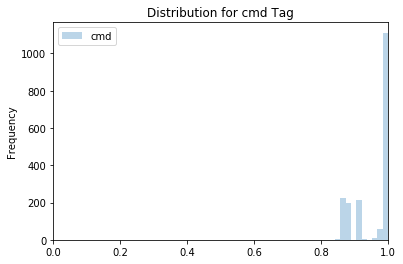

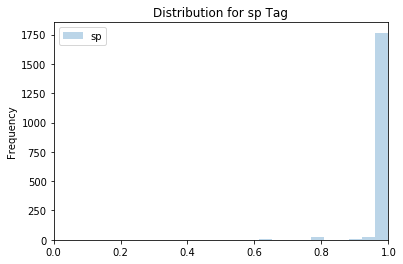

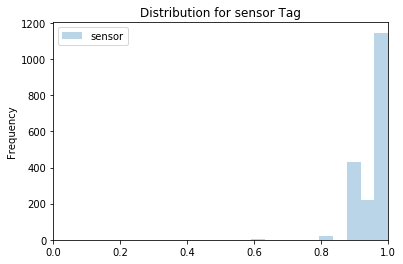

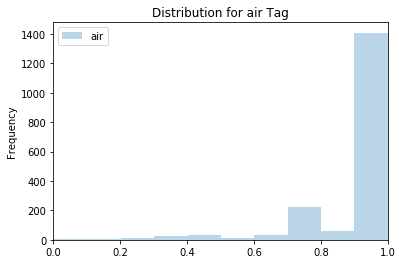

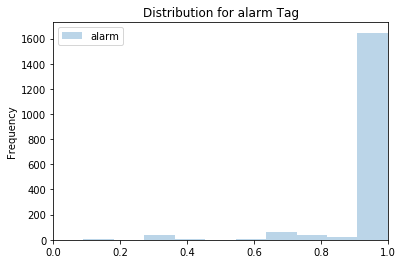

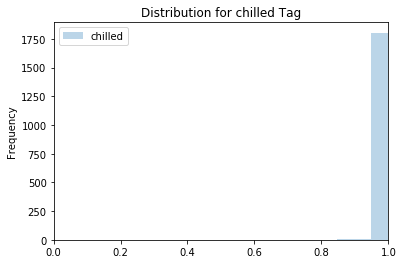

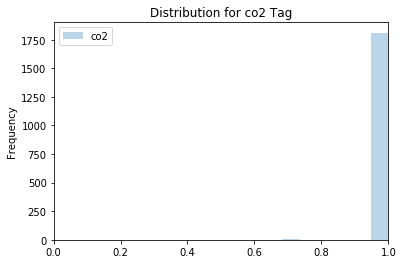

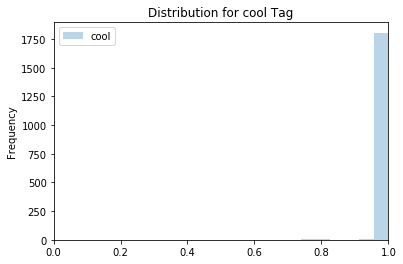

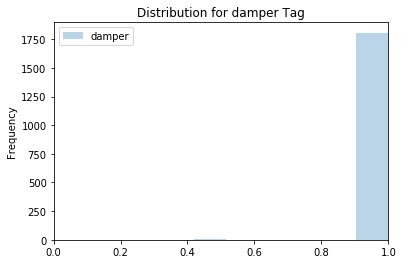

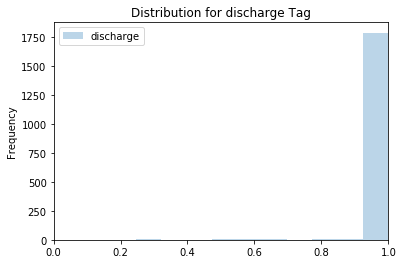

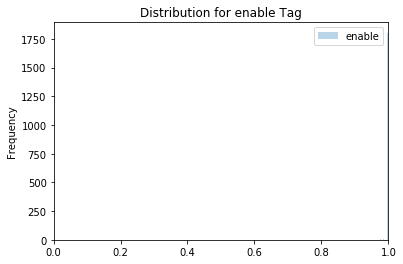

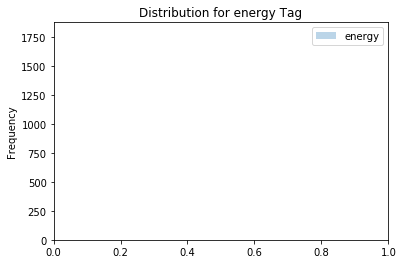

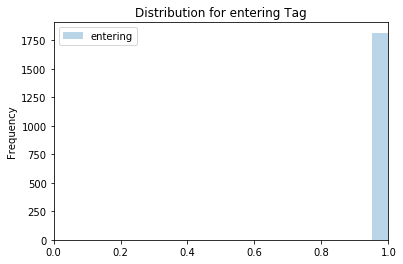

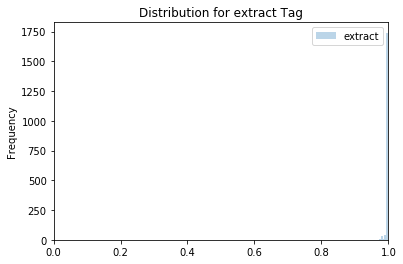

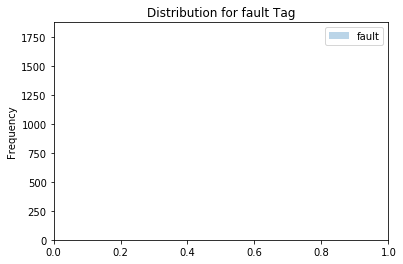

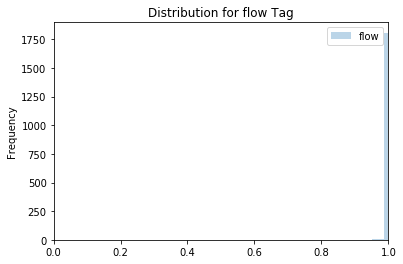

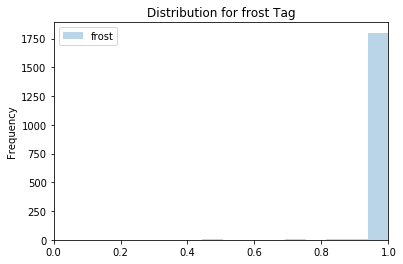

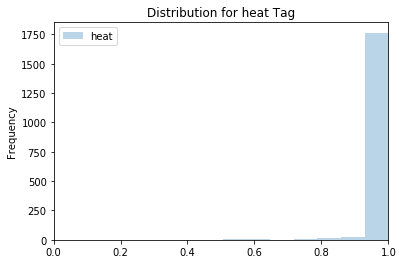

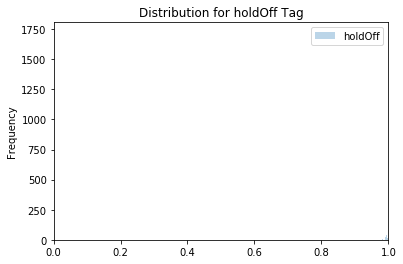

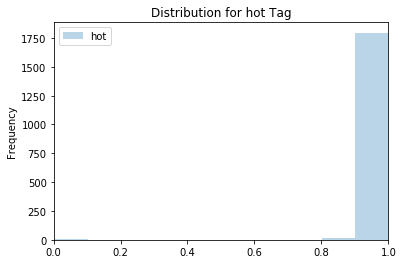

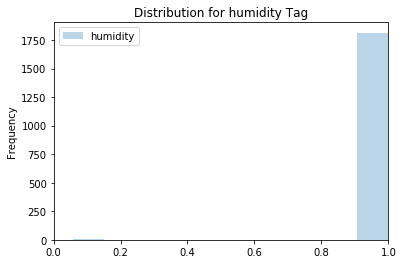

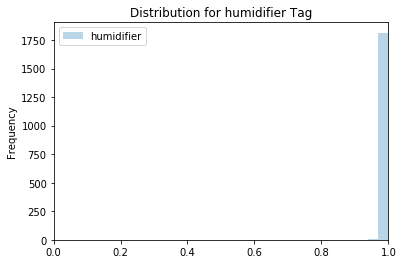

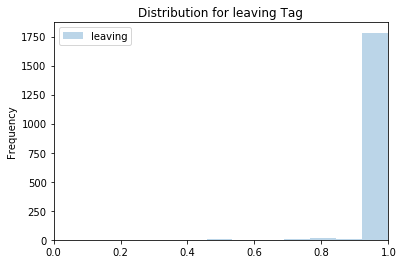

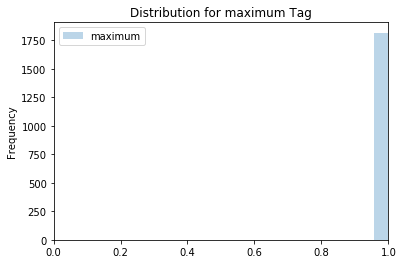

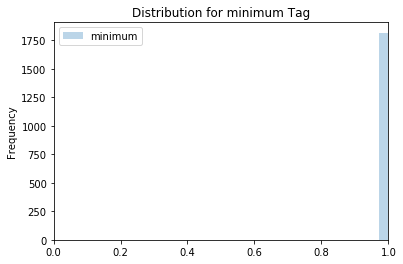

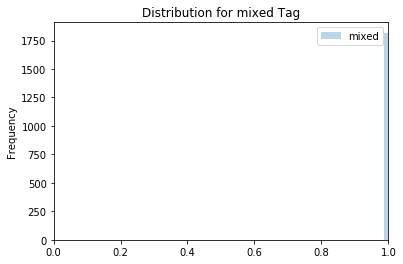

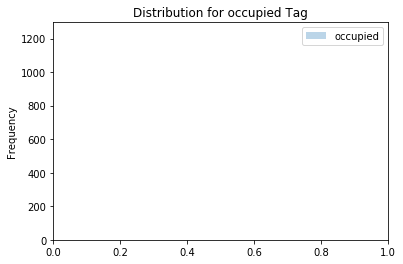

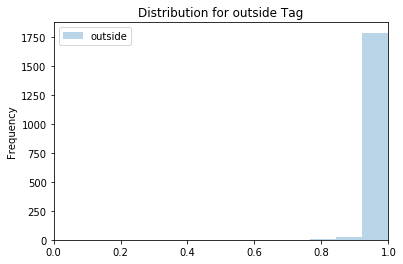

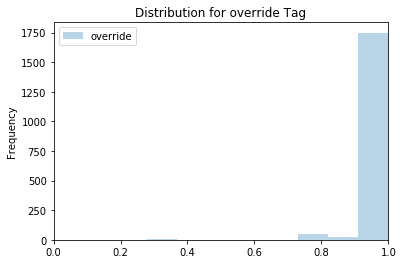

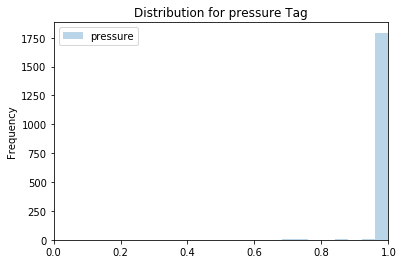

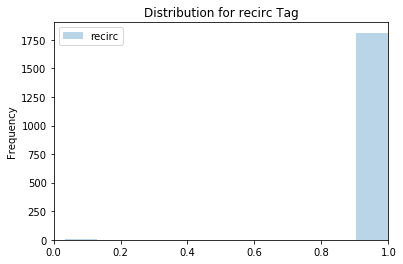

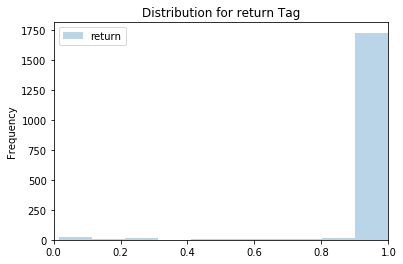

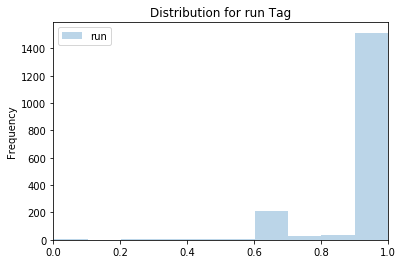

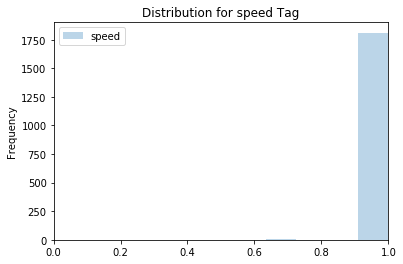

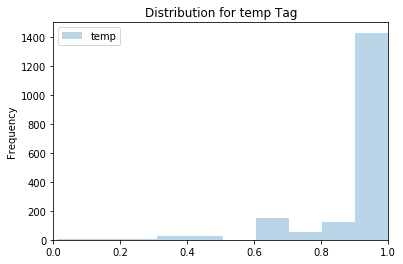

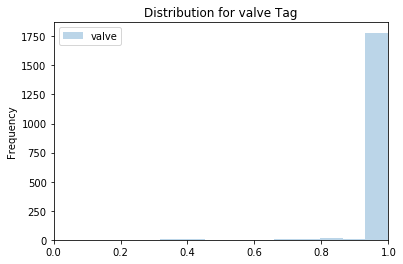

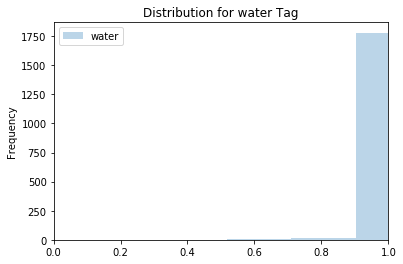

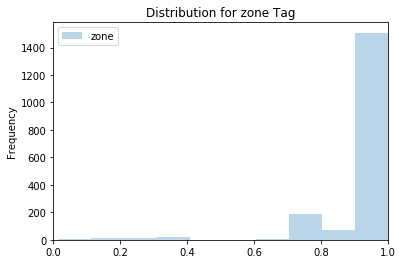

In [101]:
for category in list(confi_df):
    hist = confi_df[[category]].plot.hist(bins=10, alpha=0.3, title = "Distribution for " + category  + " Tag", xlim = (0,1))

# Service type

In [102]:
#serviceType = data_serviceType["serviceType"].str.lower().values.tolist()

serviceType_train = serviceType_train.applymap(lambda s:s.lower() if type(s) == str else s)
serviceType_test = serviceType_test.applymap(lambda s:s.lower() if type(s) == str else s)

serviceType_train = serviceType_train.values.tolist()
serviceType_test = serviceType_test.values.tolist()

In [103]:
serviceType_test

[['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['cooling'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['globals'],
 ['glo

In [104]:
enc_servType = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_servType.fit(serviceType_train)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [105]:
enc_servType.categories_

[array(['cooling', 'globals', 'heating', 'lighting', 'metering',
        'monitoring', 'terminals', 'ventilation'], dtype=object)]

In [106]:
serviceType_train = enc_servType.transform(serviceType_train)
serviceType_test = enc_servType.transform(serviceType_test)

serviceType_train = serviceType_train.astype('int')
serviceType_test = serviceType_test.astype('int')

In [107]:
serviceType_train_np = np.array(serviceType_train)
serviceType_test_np = np.array(serviceType_test)

In [108]:
serviceType_sparse_train = sparse.csr_matrix(serviceType_train)
serviceType_sparse_test = sparse.csr_matrix(serviceType_test)

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [110]:
#Preparing new test data (test_1 + predictions)
#spredictions = sparse.csr_matrix(predictions_2) 
spredictions = sparse.csr_matrix(results_2) 
sX_test_3 = sparse.hstack([sX_test_2,spredictions])
#sX_test_3 = sX_test

#Preparing new training data (train_1 + y_train_1)
sX_train_3 = sparse.hstack([sX_train_2,y_train_2])
#sX_train_3 = sX_train

In [111]:
#y_train_1_XGBoost = np.argmax(serviceType_train.toarray(), axis=1)
#y_test_1_XGBoost = np.argmax(serviceType_test.toarray(), axis=1)

In [112]:
%%time

# initialize label powerset multi-label classifier
classifier_1 = XGBClassifier()

# train
classifier_1.fit(sX_train_3, serviceType_train_np)

# predict
predictions_train = classifier_1.predict(sX_train_3)
predictions = classifier_1.predict(sX_test_3)
#predictions_val = classifier_1.predict(data_val)

# accuracy
print("Train Accuracy = ",accuracy_score(serviceType_train_np,predictions_train))
print("Test Accuracy = ",accuracy_score(serviceType_test_np,predictions))
print("\n")

ValueError: bad input shape ()

In [210]:
predictions

array(['ventilation', 'ventilation', 'ventilation', ..., 'ventilation',
       'ventilation', 'ventilation'], dtype='<U11')